# [CoE202] note 10. RNN character prediction (Pytorch)

- Class Date : 21.06.03.
- Office Hour : -----------
- If you have any questions, ask via KLMS Q&A board or come to TA office hour to get our help.

1. Let's begin with importing the usual suspects.

In [ ]:
# this is just an annotation
# import numpy as np # this is for importing numpy library (and we will use abbreviation np for that)
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import numpy.matlib 
import math, random

from IPython.display import clear_output

2. and a few more libraries to handle the text data.

In [ ]:
# additional libraries for txt file I/O and processing string type data
!pip install unidecode
import unidecode
import string
import re

3. and load txt data from Google drive!

In [ ]:
# load text file
from google.colab import drive
drive.mount('/content/drive')

#datatxtfile = "/content/drive/My Drive/01_LectureNotes/CoE202/Colab/data/shakespeare.txt"
datatxtfile = "/content/drive/My Drive/01_LectureNotes/CoE202/Colab/data/NYT2.txt"

file = unidecode.unidecode(open(datatxtfile, "r").read())
file_len = len(file)
print('file_len =', file_len)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
file_len = 7137


4. To process the data (convert string to array), we need to find which characters are used (we need a list of used characters)!

In [ ]:
character_list = list(set(file))
print(character_list) # find all characters
n_characters = len(character_list) # number of characters found in the text

characters = ''.join(character_list) # convert  the list of characters into a string
print(characters) 

['V', 'A', '0', 'g', 'j', 'n', 's', '&', 'E', '9', '4', 'D', 'r', 'v', '-', 'K', ' ', '8', '.', 'H', "'", 'f', 'z', ',', 'W', '5', 'U', 'e', 'F', ':', '1', 'm', '?', '6', 't', 'x', 'd', 'y', 'J', 'p', 'B', 'i', 'T', 'w', 'o', 'M', '2', 'C', '"', 'k', 'Y', 'h', 'u', 'S', 'I', 'O', 'b', 'c', 'R', '3', 'N', 'a', 'l', 'P', '7', 'q']
VA0gjns&E94Drv-K 8.H'fz,W5UeF:1m?6txdyJpBiTwoM2C"kYhuSIObcR3NalP7q


5. Using the list, we are going to define a function that converts a string into numbers.

In [ ]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        #print(string[c])
        tensor[c] = characters.index(string[c])
    return tensor

# test run
print(char_tensor('abcDEF'))

tensor([61, 56, 57, 11,  8, 28])


6. Here's another function which samples a random chuck of text from the data.

In [ ]:
chunk_len = 64 # length of sequence

# find the locations of space (' ') characters (which we will use as the starting points for sampling)
init_sentence = []
for i in range(file_len-1):
    if file[i]==' ':        
        init_sentence.append(i+1)

idx_init_sentence = np.array(init_sentence)
count_init = len(idx_init_sentence)
idx_count = np.arange(count_init)
last_idx = idx_count[file_len - idx_init_sentence > chunk_len][-1]

# randomly sample a string
def random_chunk():
    #start_index = random.randint(0, file_len - chunk_len - 1) # random location
    start_index = idx_init_sentence[random.randint(0, last_idx - 1)] # random location (after space)
    end_index = start_index + chunk_len 
    return file[start_index:end_index]


# test run
print(random_chunk())

that 70 to 90 percent of the population needs to acquire resista


7. We are going to formulate this as a character prediction problem. For that, we need to further process the data and turn it into one-hot encoded form.

In [ ]:
# turn a batch of string into one-hot coded form
def convert_onehot(input_tensor, num_class):
    # input_tensor: time x batch
    # output_tensor: time*batch x num_class
    # output_reshape: time x batch x num_class
    
    output_tensor = torch.zeros( input_tensor.shape[0]*input_tensor.shape[1], num_class) # create 2D output tensor
    input_tensor_reshape = input_tensor.reshape(input_tensor.shape[0]*input_tensor.shape[1]) # reshape 2D tensor to 1D

    # go through each entity in the reshaped input tensor and do one-hot coding
    # e.g., [0 2 1 0 1 1] --> [1 0 0 0; 0 0 0 1; 0 1 0 0; 1 0 0 0; 0 1 0 0; 0 1 0 0]
    for i in range(len(input_tensor_reshape)):
        #################################################################################
        ### ACTIVITY  : fill in this part 

        #################################################################################

    output_reshape = output_tensor.reshape(input_tensor.shape[0], input_tensor.shape[1], num_class) # reshape 2D output tensor to 3D

    return output_reshape

8. Here's our function that samples a batch for training. This uses the functions that we defined earlier.

In [ ]:
# randomly sample a batch (inp_onehot: input, one-hot coded, target: output, scalar-valued)
def random_training_set(batchsize, n_characters):    

    for i in range(batchsize):
        chunk = random_chunk()

        if i==0:
                inp = torch.reshape(char_tensor(chunk[:-1]), (1,-1))
                target = torch.reshape(char_tensor(chunk[1:]), (1,-1))
        else:
            inp_current = torch.reshape(char_tensor(chunk[:-1]), (1,-1))
            target_current = torch.reshape(char_tensor(chunk[1:]), (1,-1))            
            inp = torch.cat( (inp, inp_current), 0)
            target = torch.cat( (target, target_current), 0)
        
    # size at this point
    # inp :   batch x time
    # target: batch x time
    inp_onehot = convert_onehot(inp, n_characters)    
    target = target.long()

    return inp_onehot, target

9. Here's just one utility function for "thresholding" RNN output.

In [ ]:
# utility function for "thresholding" RNN output ([0.2 0.4 0.1 0.1 0.1] --> [0 1 0 0 0])
def threshold_onehot(in_onehot):
    out_onehot = torch.zeros_like(in_onehot)

    for bi in range(out_onehot.shape[0]):
        for ti in range(out_onehot.shape[1]):
            in_slice = in_onehot[bi,ti,:]
            _, pred_label = torch.max(in_slice, 0)
            out_onehot[bi,ti,pred_label] = 1
            
    return out_onehot

10. Now, let's define our RNN. We are going to use RNNCell as our unit cell. We are going to attach a decoder (linear layer) to convert the hidden value to the output.

In [ ]:
# Define RNN
class simplernn(nn.Module):
    def __init__(self, batch_size, n_inputs, hidden_size, output_size):
        super(simplernn, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.rnn = nn.RNNCell(n_inputs, hidden_size)    
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input):      

        # transform to 'time x batch x n_input'
        input = input.permute(1, 0, 2) 

        tlength = input.shape[0]
        batchsize = input.shape[1]


        # Forward pass through time
        for i in range(tlength):
            #################################################################################
            ### ACTIVITY  : fill in this part 
            # self.hx =       # self.hx is  obtained by passing the current input (input[i]), previous self.hx through the RNN
            # current_out     # current output is obtained by passing self.hx through the decoder        
            # current_output  # current_output needs to be reshaped to 3D before we can concatenate with output
                              # batch x n_input --> 1 x batch x n_input

                              
            #################################################################################

            if i==0:
                output = current_out
            else:
                output = torch.cat( (output, current_out), 0)
            

        # reshape output 
        output = output.permute(1, 0, 2) 

        return output, self.hx

    def init_hidden(self):
        self.hx = torch.zeros(self.batch_size, self.hidden_size) # initialize hidden state

11. Let's set the hyper parameters.

In [ ]:
# set hyper-parameters
batchsize = 64 # should be an integer multiple of 16
n_epochs = 200
n_samples = 100

hidden_size = 512
lr = 0.0001

print_every = 1
plot_every = 20
gen_every = 5

12. Let's create the network and optimizer instances.

In [ ]:
model = simplernn(batchsize, n_characters, hidden_size, n_characters) # create RNN instance
model.init_hidden() # initialize hidden value
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # set optimizer
criterion = nn.CrossEntropyLoss() # set loss function

13. Just another function for testing our RNN. We give some initial characters to RNN and let it generate strings.

In [ ]:
# generate a test input and apply to RNN for text generation
def generate_text():
    t1 = char_tensor('A').view(1, -1)
    t2 = char_tensor('B').view(1, -1)
    t3 = char_tensor('C').view(1, -1)
    t4 = char_tensor('D').view(1, -1)
    t5 = char_tensor('E').view(1, -1)
    t6 = char_tensor('F').view(1, -1)
    t7 = char_tensor('H').view(1, -1)
    t8 = char_tensor('I').view(1, -1)
    t9 = char_tensor('J').view(1, -1)
    t10 = char_tensor('K').view(1, -1)
    t11 = char_tensor('M').view(1, -1)
    t12 = char_tensor('N').view(1, -1)
    t13 = char_tensor('O').view(1, -1)
    t14 = char_tensor('P').view(1, -1)
    t15 = char_tensor('T').view(1, -1)
    t16 = char_tensor('U').view(1, -1)

    test_tensor = torch.cat(( t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16), 0)
    test_tensor_onehot = convert_onehot( test_tensor, n_characters)

    repeatcount = int(np.floor(batchsize/16))
    test_input_init = test_tensor_onehot.repeat(repeatcount, 1, 1)

    model.init_hidden()
    tlength = 95
    test_input = test_input_init
    output_all = test_input
    for ti in range(tlength):
        outputs, hidden = model(test_input)
        test_input = threshold_onehot(outputs)
        output_all = torch.cat( (output_all, outputs), 1)

    return output_all

14. Another function to print out generated strings (so many functions...)

In [ ]:
# print generated text
def print_text(text_in):
    for bi in range( np.minimum(16, text_in.shape[0]) ):
        text_example = text_in[bi,:,:]
        _, pred_label = torch.max(text_example, 1)
        for i in range(len(pred_label)):
            print(characters[pred_label[i]], end = '')
        print('')

15. Ok, now let's generate a string using untrained RNN.

In [ ]:
# generate text using untrained RNN
output_all = generate_text()
print_text(output_all)

AkkWWk1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS
BkkWWk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1W
CkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1W
DkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1W
EkkkakaWkWWk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11Wk
FkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1W
HkkkakaWkWWk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11Wk
IkkWWk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1WS11WkkWkk1W
JkkWWk1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS
KkkWWk1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS1WS
MkkWWk1WS1WS1WS1WS1WS1WS1WS1WS

16. Here is our function for plotting learing curves.

In [ ]:
def plt_curve():
    clear_output(True)
    plt.figure(figsize=[16, 9])
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(loss_history)

    plt.subplot(1,2,2)
    plt.title("Accuracy")
    plt.plot(accuracy_history)
    
    plt.grid()
    plt.show()

17. Here's our main loop for training.

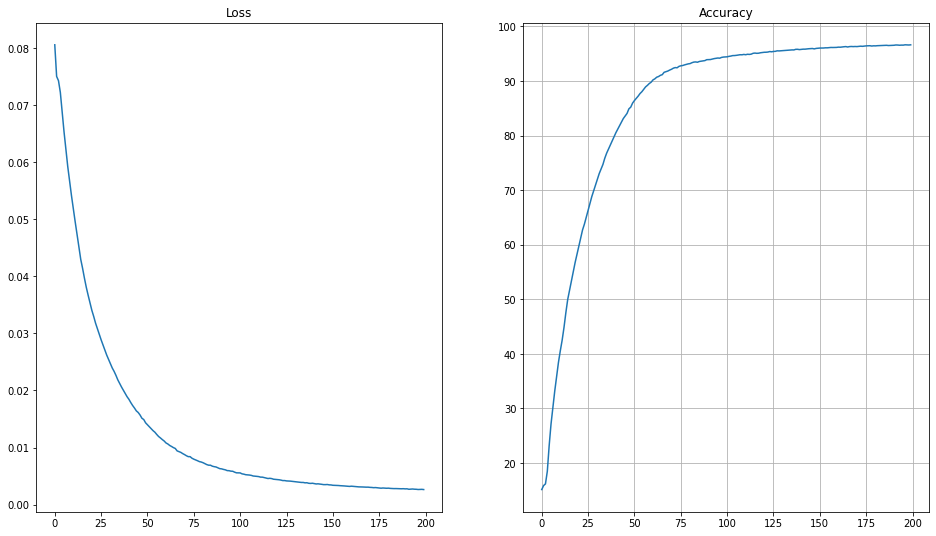

(epoch 200/200) loss_avg: 0.002633, accuracy:  96.611359 %
Alaska, North Dakota and Utah, are supposed to receive supplements for tribal governments that h
But states create and implement their own plans, and sometimes counties deviate from those plans
C.D.C. is now including the Johnson & Johnson vaccine in its data. People receiving this single-
Disease Control and Prevention, which updates data daily. The federal data may differ from that 
Every state except Montana has expanded its occupation-based vaccination program to include some
Feb. 20. Some states, including Alaska, North Dakota and Utah, are supposed to receive supplemen
Health Service. In addition to delivering vaccines to states, territories and some federal agenc
Is Eligible for a Vaccine? Health care workers and residents of long-term care facilities have b
Johnson & Johnson's single-dose vaccine or the two-dose series made by Pfizer-BioNTech and Moder
Kansas, U.S. Postal Service workers are eligible for the vaccine if 

In [ ]:
# start training RNN
loss_history = []
accuracy_history = []

loss_avg = 0

for epoch in range(1, n_epochs + 1):
    
    train_running_loss = 0.0
    correct_cnt = 0
    all_cnt = 0
    model.train()
    
    for iter in range(n_samples):
        inp_onehot, target = random_training_set(batchsize, n_characters) 

        model.init_hidden()
        model.zero_grad()
        loss = 0

        # forward + backward + optimize
        outputs, hidden = model(inp_onehot)


        loss = criterion(outputs.permute(0, 2, 1) , target)
        
        loss.backward()
        optimizer.step()

        _, pred_label = torch.max(outputs.permute(0, 2, 1), 1)
        correct_cnt += (pred_label == target.data).sum().item()
        all_cnt += pred_label.data.size(0)*pred_label.data.size(1)

        train_running_loss += loss.detach().item()


    model.eval()
    
    loss_avg = 100*train_running_loss /(chunk_len*n_samples*batchsize)
    accuracy_avg = 100*correct_cnt/all_cnt
    loss_history.append(loss_avg)
    accuracy_history.append(accuracy_avg)

    if epoch % plot_every == 0:    
        plt_curve()

    if epoch % print_every == 0:
        print('(epoch %i/%i) loss_avg: %f, accuracy:  %f %%' % (epoch, n_epochs, loss_avg, accuracy_avg))

    if epoch % gen_every == 0:    
        output_all = generate_text()
        print_text(output_all)


18. Let's generate some strings using the trained RNN.

In [ ]:
output_all = generate_text()
print_text(output_all)

Alaska, North Dakota and Utah, are supposed to receive supplements for tribal governments that h
Biden recently announced plans to expand supply and to give states more advance notice about the
C.D.C. reported about 4.6 million new doses administered, including about 1.6 million doses that
Disease Control and Prevention, which updates data daily. The federal data may differ from that 
Eligible for a Vaccine? Health care workers and residents of long-term care facilities have been
Feb. 27. The federal government has delivered about 135.8 million doses to states, territories a
Health care workers and residents of long-term care facilities have been eligible for vaccinatio
Is Each State Performing? Some jurisdictions have been more efficient than others at administeri
Johnson & Johnson's single-dose vaccine or the two-dose series made by Pfizer-BioNTech and Moder
Kansas, U.S. Postal Service workers are eligible for the vaccine if they regularly need to be in
Moreand Prepentiog verimmont h